In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.signal import dlsim, butter, lfilter

# Testbench parameters

In [2]:
def new_parameters():
    inertias = np.array([7.94e-4,
                         3.79e-6,
                         3.00e-6,
                         2.00e-6,
                         7.81e-3,
                         2.00e-6,
                         (3.17e-6 - 7800*(np.pi*(0.006**4)/32)*0.342/6) + 7800*(np.pi*(0.008**4)/32)*0.342/6,
                         5.01e-5,
                         6.50e-6,
                         5.65e-5,
                         4.27e-6,
                         3.25e-4,
                         1.20e-4,
                         1.15e-5,
                         1.32e-4,
                         4.27e-6,
                         2.69e-4,
                         1.80e-4,
                         2.00e-5,
                         2.00e-4,
                         4.27e-6,
                         4.95e-2])

    stiffnesses = np.array([1.90e5,
                            6.95e3,
                            90.00,
                            90.00,
                            90.00,
                            90.00,
                            80e9*(np.pi*(0.008**4)/32)/0.342,
                            4.19e4,
                            5.40e3,
                            4.19e4,
                            1.22e3,
                            4.33e4,
                            3.10e4,
                            1.14e3,
                            3.10e4,
                            1.22e4,
                            4.43e4,
                            1.38e5,
                            2.00e4,
                            1.38e5,
                            1.22e4])

    damping = np.array([8.08,
                        0.29,
                        0.24,
                        0.24,
                        0.24,
                        0.24,
                        0.00,
                        1.78,
                        0.23,
                        1.78,
                        0.52,
                        1.84,
                        1.32,
                        0.05,
                        1.32,
                        0.52,
                        1.88,
                        5.86,
                        0.85,
                        5.86,
                        0.52])


    external_damping = np.array([0.0030,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.0038,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.0038,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.2400])

    gear_ratios = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1/3, 1, 1, 1, 1, 1/4, 1, 1, 1, 1])

    return inertias, stiffnesses, damping, external_damping, gear_ratios


# State-space matrices

The state-space matrices are constructed the same way as in the master's thesis and the MSSP article.

In [3]:
def state_space_matrices(inertia, stiff, damp, damp_ext, ratios, full_B=False):
    """
    Parameters:
    
    inertia : list
        The inertia values of each lumped mass in order from index 1...n
    stiff : list
        The stiffness values between each lumped mass in order from index 1...n
    damp : list
        The viscous damping values between each lumped mass in order from index 1...n
    damp_ext : list
        The external damping corresponding to torque losses from the motors and gears
    ratios : list
        The gear ratios between each lumped mass
    full_B : bool
        If true, the input matrix B is shape n x p, allowing applying an input at the
        location of every lumped mass. By default it's shape is n x 2, for applying an input
        at the locations corresponding to the driving motor and the propeller. 
        
    Returns:
    
    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    D : numpy.ndarray
        The feedthrough matrix, always a zero matrix

    """
    cn = damp*ratios
    cn2 = damp*ratios**2
    cn2 = np.hstack((cn2, 0))
    c0 = np.copy(damp)
    c0 = np.insert(c0, 0, 0, axis=0)
    cn2d = -(c0 + cn2 + damp_ext)

    A11 = (np.diag(cn2d) + np.diag(cn, k=1) + np.diag(cn, k=-1)) / inertia.reshape(inertia.shape[0], 1)

    ks = -np.hstack((stiff*ratios, 0))
    A12 = np.delete(
        (np.diag(ks) + np.diag(stiff, k=-1)) / inertia.reshape(inertia.shape[0], 1), -1, axis=1
    )


    A23 = np.delete(
        np.diag(np.hstack((ratios, 0))) + np.diag(-np.ones(len(ratios)), k=1), -1, axis=0
    )

    A = np.vstack((np.hstack((A11, A12)), np.hstack((A23, np.zeros((A23.shape[0], A23.shape[1]-1))))))

    if full_B:
        B = np.zeros(A.shape)
        for i in range(len(inertia)):
            B[i,i] += 1/inertia[i]
    else:
        B = np.zeros((A.shape[0], 2))
        B[0,0] += 1/inertia[0]
        B[len(inertia)-1, 1] -= 1/inertia[-1]

    C = np.zeros((3, A.shape[0]))
    C[0,6] += 1
    C[1,7] += 1
    C[2,30] += 5400
    D = np.zeros((C.shape[0], B.shape[1]))

    return A, B, C, D

In [4]:
def c2d(A, B, ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time ts.
    The function returns matrices Ad, Bd of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]

    return Ad, Bd


# Data equation matrices

In [5]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))

    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O


def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)

    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B,
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z

        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))

        # then add the impulse responses
        A_power2 = np.copy(A)

        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))

        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))

        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1

    return gamma


def second_difference_matrix(n, m):
    D2 = np.eye(n*m) - 2*np.eye(n*m, k=2) + np.eye(n*m, k=4)

    # delete incomplete rows
    D2 = D2[:-2*m, :]

    return D2


# Load ice excitation and measurement data

This dataset was used in the master's thesis for the ice excitation experiments on the testbench. Sampling frequency ~1 kHz. The data has been low pass filtered with a cutoff frequency of 500 Hz.

In [6]:
# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data = np.loadtxt("../data/masters_data/processed_data/ice_2000_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data = np.loadtxt("../data/masters_data/processed_data/ice_2000_sensor.csv", delimiter=",")

In [7]:
time = sensor_data[:,0]
measurements = sensor_data[:,1:] # measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
motors = np.vstack((motor_data[:,2], motor_data[:,4])).T # motor torque data

In [8]:
motor = motors[:,0]
propeller = motors[:,-1]

# Initiate the input and state estimation procedure

In [9]:
def get_testbench_state_space(dt):
    inertias, stiffs, damps, damps_ext, ratios = new_parameters()
    Ac, Bc, C, D = state_space_matrices(inertias, stiffs, damps, damps_ext, ratios)

    A, B = c2d(Ac, Bc, dt)

    return A, B, C, D

In [10]:
dt = np.mean(np.diff(time))
A, B, C, D = get_testbench_state_space(dt)
ss = (A, B, C, D)

In [11]:
# include second torque transducer
C_mod = np.insert(C, 3, np.zeros((1, C.shape[1])), 0)
C_mod[3,22+18] += 2e4
D_mod = np.zeros((C_mod.shape[0], B.shape[1]))

In [12]:
# parameters for the input and state estimation
batch_size = 500
overlap = 100
lam = 0.1

# Analytical solution of the $\ell_2$ regularized LS problem

In [13]:
def progressbar(it, prefix="", size=60, out=sys.stdout):
    """
    A function used to display a progress bar in the console.
    """
    count = len(it)
    def show(j):
        x = int(size*j/count)
        print(f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count}", end='\r', file=out, flush=True)
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

In [14]:
def get_data_equation_matrices(A, B, C, D, n, bs):
    D2 = second_difference_matrix(bs, B.shape[1])
    O_mat = O(A, C, bs)
    G = gamma(A, B, C, bs)
    L = np.eye(bs*B.shape[1])

    return O_mat, G, D2, L

In [15]:
def ell2_analytical(ss, measurements, batch_size, overlap, times, lam=0.1, use_trend_filter=False):

    dt = np.mean(np.diff(times))
    n = len(times)
    bs = batch_size + 2*overlap
    loop_len = int(n/batch_size)

    A, B, C, D = ss  # state space model
    O_mat, G, D2, L = get_data_equation_matrices(A, B, C, D, n, bs)  # data equation matrices

    if use_trend_filter:
        regul_matrix = D2 # regularization matrix
    else:
        regul_matrix = L

    H = np.hstack([O_mat, G])  # extended observation and impulse response matrix
    M = np.hstack([np.zeros((regul_matrix.shape[0], O_mat.shape[1])), regul_matrix])  # extended regularization matrix
    
    input_estimates = []

    for i in progressbar(range(loop_len), "Calculating estimates: ", loop_len):
        if i == 0:
            batch = measurements[:bs,:]
        elif i == loop_len-1:
            batch = np.zeros((bs, measurements.shape[1]))
            # zero padding to finish estimation loop correctly
        else:
            batch = measurements[i*batch_size-overlap:(i+1)*batch_size+overlap,:]

        y = batch.reshape(-1,1)

        estimate = LA.inv(H.T @ H + lam*(M.T @ M)) @ H.T @ y

        input_estimates.append(estimate)

    return input_estimates


In [16]:
times = time[:measurements.shape[0]]
estimates = ell2_analytical(ss, measurements[:,:3], batch_size, overlap, times, lam=lam, use_trend_filter=True)
print(estimates[1].shape)

Calculating estimates: [████████████████████] 20/20

(1443, 1)


In [17]:
n_batches = 20
motor_estimates, propeller_estimates = [], []
motor_est_overlap, prop_est_overlap = [], []
for i in range(n_batches):
    if i == 0:
        all_motor_estimates = estimates[i][43::2]
        motor_est_overlap.append(all_motor_estimates)
        motor_estimates = all_motor_estimates[:-2*overlap]
        all_propeller_estimates = estimates[i][(43+1)::2]
        prop_est_overlap.append(all_propeller_estimates)
        propeller_estimates = all_propeller_estimates[:-2*overlap]
    else:
        all_motor_estimates = estimates[i][43::2]
        motor_est_overlap.append(all_motor_estimates)
        motor_estimates = np.concatenate(
            (motor_estimates, all_motor_estimates[overlap:-overlap])
        )
        all_propeller_estimates = estimates[i][(43+1)::2]
        prop_est_overlap.append(all_propeller_estimates)
        propeller_estimates = np.concatenate(
            (propeller_estimates, all_propeller_estimates[overlap:-overlap])
        )

In [20]:
C_full = np.eye(B.shape[0])
omat = O(A, C_mod, batch_size+2*overlap)
gmat = gamma(A, B, C_mod, batch_size+2*overlap)

In [28]:
U_est = np.hstack((motor_estimates, propeller_estimates))

In [31]:
tout, yout, xout = dlsim((A, B, C_mod, D_mod, dt), U_est, t=times[:-67])

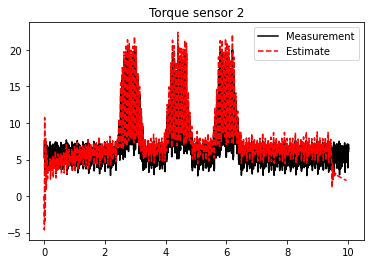

In [36]:
%matplotlib inline
plt.title("Torque sensor 2")
plt.plot(times, measurements[:,-1], c='black', label="Measurement")
plt.plot(tout, yout[:,-1], '--', c='red', label="Estimate")
plt.legend()

# Below code is incomplete

In [25]:
state_estimates = []
all_inputs = []
for i in range(n_batches):
    inputs = np.vstack((motor_est_overlap[i], prop_est_overlap[i])).ravel(order='C')
    inputs = inputs.reshape(len(inputs), 1)
    all_inputs.append(inputs)
    #state_estimates.append(omat @ estimates[i][:43] + gmat @ inputs)
    state_estimates.append(omat @ np.zeros((43,1)) + gmat @ inputs)
print(state_estimates[0].shape)

(2800, 1)


In [26]:
speed1_ests, speed2_ests, torque1_ests, torque2_ests = [], [], [], []
for i, v in enumerate(state_estimates):
    torque2_est = v[3::4]
    if i == 0:
        torque2_ests = torque2_est[:-2*overlap]
    else:
        torque2_ests = np.concatenate(
            (torque2_ests, torque2_est[overlap:-overlap])
        ) 

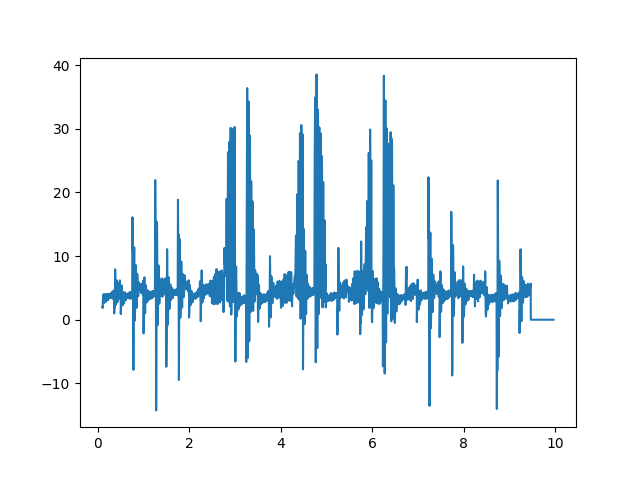

In [27]:
plt.plot(times[100:-67], torque2_ests[100:])